## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, I'll import the libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
# Read the dataset
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape[0] #show the number of rows in the dataset.

294478

In [4]:
#The number of unique users in the dataset.
df['user_id'].nunique() 

290584

a. The proportion of users converted.

In [5]:
#calculate the proportion of users converted.
df.query('converted == 1').count()[0]/df.shape[0] 

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
#calculate The number of times the new_page and treatment don't match
len(df[(df['landing_page'] == "new_page") != (df['group'] == "treatment")])

3893

In [7]:
# check for missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows that cannot be sure if this row truly received the new or old page. So,I'll drop the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page** and craete a new dataset that **treatment** match with **new_page** and **control** match with **old_page** and Store new dataframe in **df2**.

In [8]:
#drop rows where treatment does not match with new_page or control does not match with old_page
df2 = df.drop(df[(df['landing_page'] == "new_page") != (df['group'] == "treatment")].index)


In [9]:
#checking the new datframe
df2.sample(10)

,user_id,timestamp,group,landing_page,converted
223261,912431,2017-01-24 12:26:24.513120,control,old_page,0
257858,805569,2017-01-05 05:53:32.091323,treatment,new_page,0
160528,767314,2017-01-20 02:37:03.937101,treatment,new_page,0
36219,632229,2017-01-21 16:10:03.566497,control,old_page,0
99367,703771,2017-01-12 20:34:26.812313,control,old_page,1
31109,796844,2017-01-23 18:10:10.239803,control,old_page,0
135556,689331,2017-01-13 16:50:55.346216,control,old_page,0
206063,805098,2017-01-06 09:50:31.340127,treatment,new_page,0
130988,816951,2017-01-15 18:12:31.618593,treatment,new_page,0
5626,644529,2017-01-15 03:19:59.661833,treatment,new_page,0


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') != (df2['landing_page'] == 'new_page'))].shape[0]

0

In [11]:
#calculate how many unique user_ids are in df2
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
# checking for if there are users id repeated in df2
df2.user_id.value_counts()

773192    2
630732    1
811737    1
797392    1
795345    1
         ..
650647    1
648598    1
654741    1
652692    1
630836    1
Name: user_id, Length: 290584, dtype: int64

In [13]:
#show the row information for the repeat user_id
df2.loc[df2['user_id'] == 773192] 

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
# Remove one of the rows with a duplicate user_id
df2 = df2.drop(df.index[2893]) 

In [15]:
 #check the row that was repeating
df2.loc[df2['user_id'] == 773192]    

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4. What is the probability of an individual converting regardless of the page they receive?

In [16]:
# calculate the probability of an individual converting regardless of the page they receive
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
#compute converted rate for control group
converted_old = df2.query('group == "control"')['converted'].mean()
converted_old

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
#compute converted rate for treatment group
converted_new = df2.query('group == "treatment"')['converted'].mean() 
converted_new

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
# calculate the probability that an individual received the new page
df2.query('landing_page == "new_page"').count()[0]/df2.shape[0]

0.5000619442226688

**I will use these results from probablity part, and explain in A/B Test part below whether there is sufficient evidence to conclude that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test


`1.` For now, I'll assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%,so the null and alternative hypotheses would be:

**H0**: $p_{new}$ - $p_{old}$ = 0

**H1**: $p_{new}$ - $p_{old}$ > 0

Assumed under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I'll use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

then I'll Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
#compute conversion rate for 𝑝𝑛𝑒𝑤 under the null
p_new = df2.query('converted == 1')['user_id'].nunique()/(df2.user_id.nunique())
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
# conversion rate for 𝑝𝑜𝑙𝑑 under the null
#under the null hypothesis,  𝑝𝑛𝑒𝑤 and 𝑝𝑜𝑙𝑑 are equal
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
# compute the number of individuals in the treatment group as n_new
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
#compute the number of individuals in the control group as n_old
n_old = df2.query(" group == 'control'")['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
# Simulate 𝑛𝑛𝑒𝑤 transactions with a conversion rate of 𝑝𝑛𝑒𝑤 under the null
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
#Simulate 𝑛𝑛𝑒𝑤 transactions with a conversion rate of 𝑝old under the null
old_page_converted = np.random.binomial(1,p_old, n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
#calculate 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑
new_page_converted.mean() - old_page_converted.mean()


0.0001080076451102363

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
#simulate 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 transaction for 10,000 time
p_diffs = []

new_page_converted  = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted  = np.random.binomial(n_old,p_old, 10000)/n_old
p_diffs = new_page_converted  - old_page_converted
p_diffs

array([ 0.00107876, -0.00145441,  0.00074843, ...,  0.00017691,
       -0.00128217,  0.00012187])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

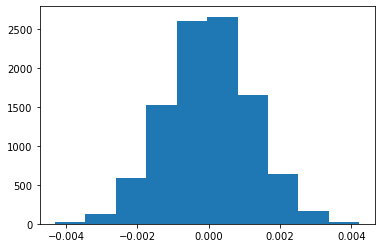

In [28]:
# Convert to numpy array
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

0.18830000000000002


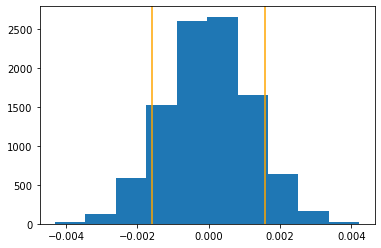

In [29]:
#compute differences in observation
obs_diff = converted_new - converted_old

# Compute p-value
low_prob = (p_diffs < obs_diff).mean()
high_prob = (p_diffs.mean() + (p_diffs.mean() - obs_diff) < p_diffs).mean()

# Plot observed statistic with the null distibution
plt.hist(p_diffs);
plt.axvline(obs_diff, color='orange');
plt.axvline(p_diffs.mean() + (p_diffs.mean() - obs_diff), color='orange');

p_val = low_prob + high_prob            
print(p_val)

> if the p-value less than type I error=0.05. it would indicate a low probability of assuming that the null hypothesis is true. I got the p-value for both directions because the alternative hypothesis is two sided and that mean have both negative value or positive can applay.


> the p-value is above 0.05 which means I fail to reject the null hypothsis so I have evidence that old page equal in converted rate with the new page.


l. I would also use a built-in to calculate the number of conversions for each page, as well as the number of individuals who received each page. where `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
#compute number of conversion for old page and new page
convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [31]:
#using stats.proportions_ztest to compute Z-test and p-value
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

number_of_success = np.array([convert_old,convert_new])
total_sample_size = np.array([n_old,n_new])

(stat,pval) = proportions_ztest(number_of_success, total_sample_size, alternative='two-sided')
print("the computed z test statistic is", stat)
print("the p-value is ",pval)

the computed z test statistic is 1.3109241984234394
the p-value is  0.18988337448195103


In [32]:
#compute the significance of z-score
from scipy.stats import norm

norm.cdf(1.31)

0.904902082204761

In [33]:
#compute crtical values at 95% confidence level
norm.ppf(1-.05)

1.6448536269514722

> the z-score I've computed means the difference between the test(the difference between conversion rates) and the null hypothesis is 1.31
standard deviation above the mean. with type I error = 0.05 and confidence level 95% the critical values are 1.96, which means z score less than the critical value so I havn't evidence to reject the null hypothesis and that mean the old page is equal the new page in converasion rates

>the p-value here is 0.189 and it is greater than alpha so I fail to reject the null hypothesis which is mean the difference between the means is not statistically significant and the old page is equal the new page in converasion rates

> this p-value I've got from z test equal the previous p-value = 0.1942
 so the z-test appears to agree with the previous findings.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part,I will fit model is attempting to predict whether a user will convert depending on their received page.
and see that if the result that achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion,I would perform Logistic Regression in this case because the the response variable is categorical variable


b. So I'll use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives. However, I'll create in df2 a column for the intercept, and I'll create a dummy variable column for which page each user received that would be an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control** to predict whether or not an individual converts. 

In [34]:
#create a column for the intercept
df2['intercept']= 1

#create dummy variable column for which page each user received
df2[['ab_page','old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


In [35]:
#drop old page and make it basline 
df2 = df2.drop('old_page', axis = 1)

In [36]:
df2.sample()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
34808,747677,2017-01-22 03:05:12.852955,treatment,new_page,1,1,1


In [37]:
# create a logistic model and fit it with the dummy variable and intercept 
log_model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_model.fit()
# show the summary of the model 
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-03-02 22:01 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

This model is attempting to predict whether a user will convert depending on the page that customer received. The null hypothesis is that when ab_page = 1, converted = 0; the alternative hypothesis is that when ab_page = 1, converted is more likely to be 1

In [38]:
np.exp(-0.0150)

0.9851119396030626

In [39]:
1/np.exp(-0.0150)

1.015113064615719

>**the p-value associated with ab_page is 0.1899 that mean p-value > alpha which means I'll fail to reject the null hypothesis 
which is similar to the previous values, but slightly smaller**.


>  from this model interpret that for every one not recieved the new page , the converted is 1.015 times as likely to happen and this not has much impact on increasing the conversion rates so it will be cost for not more icreasing in conversion rates

> and the p-value not differ much from the value I found it in a/b testing where we still reject to fail the null hypothesis



At this point, it does not appear that the treatment or control page has much impact on whether a user converts. Therefore, it is probably a good idea to add an effect based on which country a user lives in.to see if  whether effected in predicting conversion.

thus I'll create dummy variables for these country columns 

 It is important to be when selecting factors to make sure the factors are not in and of themselves collinear.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - Provide the statistical output as well as a written response to answer this question.

In [40]:
#read the data of country a user live in
country = pd.read_csv('countries.csv')
country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [41]:
#check the unique values in country column
country.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [42]:
#merage the country dataframe with the orignal dataframe
df3 = df2.merge(country, on='user_id', how='left')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [43]:
#make dummies varaible for countries
df3[['US','UK', 'CA']]= pd.get_dummies(df3['country'])

df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,UK,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [44]:
#make logistic model to predict the converted using CA and old page as baseline

log_model_2= sm.Logit(df3['converted'], df3[['intercept','ab_page' , 'CA','UK']])
results= log_model_2.fit()
results.summary2()


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-03-02 22:01 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
CA             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

Based on the p-values above, it also does not appear as though country has a significant impact on conversion.

h. Though you have now looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and conclusions based on the results.

In [45]:
#create an interaction variables between page and country to see if there significant effects on conversion
df3['CA_page'] = df3['CA']*df3['ab_page']
df3['UK_page'] = df3['UK']*df3['ab_page']
df3['US_page'] = df3['US']*df3['ab_page']


In [46]:
#make logistic model to predict the converted using an interaction variables between page and country 

log_model_3= sm.Logit(df3['converted'], df3[['intercept','CA_page','UK_page']])
results= log_model_3.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.7674
Date:               2021-03-02 22:01 BIC:              212813.5064
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.31643    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9926    0.0079  -252.9104  0.0000  -2.0081  -1.9772
CA_page      -0.0144    0.0125    -1.1548  0.2482  -0.0389   0.0101
UK_page       0.0112    0.0179     0.6256  0.5316  -0.0240   0.0464
==================================================================

"""

In [47]:
#exponentiated the CV to inteprete the result
np.exp(results.params)

intercept    0.136338
CA_page      0.985679
UK_page      1.011292
dtype: float64

In [48]:
1/np.exp(results.params)

intercept    7.334699
CA_page      1.014530
UK_page      0.988834
dtype: float64

 ### Interpreting 
 
**in this model above show** 

      there is negative relation between ab_page and converted meaning that being a new page           
      decreases the liklihood of converted by 1.02 times
      
      also there is a negative relation between Uk and converted that mean being from 
      Us decrease converted rate by 1.005
      
      and there is a negative relation between Us and converted rate that mean beaing from
      Uk increase the liklihood of convrted rate by 1.017
      
**that mean the user country and the new page that user receive doesn't affect in conversion rate**

**look at the interaction variables between page and country**

     there is a negative relation between US_new_page and converted that mean being from US and received the new page decrease the liklihood of converted rate by 1.04
     
     and I have positive relation between UK_new_page and converted that mean being from UK and received the new page increase the liklihood of converted rate by 1.03 
     
     
#### Whereas all reuslts not high enough to affect in converted rated , that's mean the page and country dataset are not a good fit to predit converted rate So I will train and test the data set to prevent or minimize overfitting.    

      
    



In [49]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0